## Import Libraries and Dependencies

In [19]:
# Import our dependencies
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib as plt
import plotly.express as px
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import sklearn as skl
import tensorflow as tf

In [20]:
# Load the data
file_path = Path("resources/processed_stroke_db_w_cat.csv")
df = pd.read_csv(file_path, index_col=[0])
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
14180,Female,13.0,0,0,No,children,Rural,103.08,18.6,Unknown,0
44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0


In [21]:
df.shape

(4909, 11)

One-hot Encoding for Categotical Data & StandScaler for Numerical Data

In [22]:
# Generate our categorical variable list
cat_labels= df.dtypes[df.dtypes == "object"].index.tolist()
print(cat_labels)

# Check the number of unique values in each column
print(df[cat_labels].nunique())



['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
gender            3
ever_married      2
work_type         5
Residence_type    2
smoking_status    4
dtype: int64


In [23]:
# Create the OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(df[cat_labels]))

encode_df.index = df.index

# Add the encoded variable names to the DataFrame
encode_df.columns = enc.get_feature_names(cat_labels)
encode_df.head()



,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
id,,,,,,,,,,,,,,,,
9046,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
31112,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
60182,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1665,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
56669,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [24]:
# Merge one-hot encoded features and drop the originals
df = df.merge(encode_df,left_index=True, right_index=True)
df = df.drop(cat_labels,1)
df.head()
df.shape

C:\Users\Kristen\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


(4909, 22)

In [25]:
# Split our preprocessed data into our features and target arrays
y = df["stroke"].values
X = df.drop(["stroke"],1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=12)

C:\Users\Kristen\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [26]:
# Create the StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Single Neuron / Single Layer Neural Network

### Train, Fit, Evaluate, Predict Model

In [27]:
# Create the Keras Sequential model
nn_model = tf.keras.models.Sequential()

# Add our first Dense layer, including the input layer
nn_model.add(tf.keras.layers.Dense(units=1, activation="relu", input_dim=21))

# Add the output layer that uses a probability activation function
nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the Sequential model
nn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 22        
                                                                 
 dense_1 (Dense)             (None, 1)                 2         
                                                                 
Total params: 24
Trainable params: 24
Non-trainable params: 0
_________________________________________________________________


In [28]:
# Compile the Sequential model together and customize metrics
nn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [29]:
# Fit the model to the training data
fit_model = nn_model.fit(X_train_scaled, y_train, validation_data = (X_test_scaled, y_test), epochs=100)

Epoch 1/100
116/116 [==============================] - 2s 8ms/step - loss: 0.7601 - accuracy: 0.5903 - val_loss: 0.6926 - val_accuracy: 0.6873
Epoch 2/100
116/116 [==============================] - 0s 4ms/step - loss: 0.6468 - accuracy: 0.8207 - val_loss: 0.6121 - val_accuracy: 0.9112
Epoch 3/100
116/116 [==============================] - 0s 4ms/step - loss: 0.5848 - accuracy: 0.9503 - val_loss: 0.5619 - val_accuracy: 0.9552
Epoch 4/100
116/116 [==============================] - 0s 4ms/step - loss: 0.5413 - accuracy: 0.9579 - val_loss: 0.5233 - val_accuracy: 0.9560
Epoch 5/100
116/116 [==============================] - 0s 4ms/step - loss: 0.5052 - accuracy: 0.9579 - val_loss: 0.4895 - val_accuracy: 0.9560
Epoch 6/100
116/116 [==============================] - 1s 4ms/step - loss: 0.4737 - accuracy: 0.9579 - val_loss: 0.4596 - val_accuracy: 0.9560
Epoch 7/100
116/116 [==============================] - 1s 5ms/step - loss: 0.4446 - accuracy: 0.9579 - val_loss: 0.4322 - val_accuracy: 0.9560

Epoch 58/100
116/116 [==============================] - 0s 4ms/step - loss: 0.1522 - accuracy: 0.9579 - val_loss: 0.1561 - val_accuracy: 0.9560
Epoch 59/100
116/116 [==============================] - 0s 4ms/step - loss: 0.1514 - accuracy: 0.9579 - val_loss: 0.1556 - val_accuracy: 0.9560
Epoch 60/100
116/116 [==============================] - 0s 4ms/step - loss: 0.1509 - accuracy: 0.9579 - val_loss: 0.1550 - val_accuracy: 0.9560
Epoch 61/100
116/116 [==============================] - 0s 4ms/step - loss: 0.1501 - accuracy: 0.9582 - val_loss: 0.1545 - val_accuracy: 0.9560
Epoch 62/100
116/116 [==============================] - 0s 4ms/step - loss: 0.1497 - accuracy: 0.9582 - val_loss: 0.1540 - val_accuracy: 0.9560
Epoch 63/100
116/116 [==============================] - 0s 4ms/step - loss: 0.1491 - accuracy: 0.9579 - val_loss: 0.1535 - val_accuracy: 0.9560
Epoch 64/100
116/116 [==============================] - 0s 4ms/step - loss: 0.1485 - accuracy: 0.9582 - val_loss: 0.1530 - val_accuracy:

In [30]:
# Create a DataFrame containing training history
nn_history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))
nn_history_df

,loss,accuracy,val_loss,val_accuracy
1,0.760051,0.590329,0.692644,0.687296
2,0.646772,0.820701,0.612071,0.911238
3,0.584834,0.950285,0.561942,0.955212
4,0.541277,0.957892,0.523253,0.956026
5,0.505216,0.957892,0.489471,0.956026
...,...,...,...,...
96,0.142192,0.958164,0.148115,0.956026
97,0.142209,0.958164,0.148055,0.956026
98,0.142144,0.958164,0.147956,0.956026
99,0.141942,0.958164,0.147926,0.956026


<AxesSubplot:>

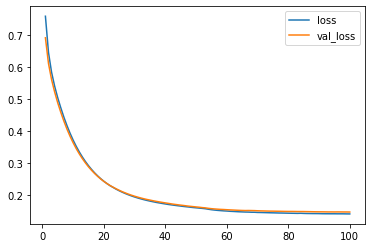

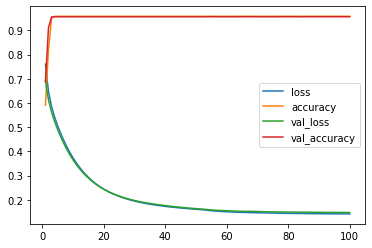

In [31]:
# Plot the loss
nn_history_df.plot(y=["loss", "val_loss"])
nn_history_df.plot()

<AxesSubplot:>

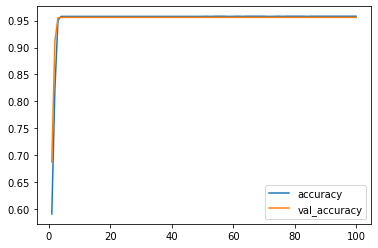

In [32]:
# Plot the accuracy
nn_history_df.plot(y=["accuracy", "val_accuracy"])

In [33]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

39/39 - 0s - loss: 0.1478 - accuracy: 0.9560 - 136ms/epoch - 3ms/step
Loss: 0.14776816964149475, Accuracy: 0.9560260772705078


## Multiple Neuron Single Layer Neural Network

In [34]:
# Generate our new Sequential model
multi_nn_model = tf.keras.models.Sequential()

# Add the input and hidden layer
number_inputs = 21
number_hidden_nodes = 6

multi_nn_model.add(tf.keras.layers.Dense(units=number_hidden_nodes, activation="relu", input_dim=number_inputs))

# Add the output layer that uses a probability activation function
multi_nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Compile the Sequential model together and customize metrics
multi_nn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Fit the model to the training data
fit_model_multi = multi_nn_model.fit(X_train_scaled, y_train, validation_data = (X_test_scaled, y_test), epochs=100, shuffle=True)

Epoch 1/100
116/116 [==============================] - 2s 7ms/step - loss: 0.8364 - accuracy: 0.4246 - val_loss: 0.6371 - val_accuracy: 0.6376
Epoch 2/100
116/116 [==============================] - 0s 4ms/step - loss: 0.5363 - accuracy: 0.8188 - val_loss: 0.4417 - val_accuracy: 0.9340
Epoch 3/100
116/116 [==============================] - 0s 4ms/step - loss: 0.3836 - accuracy: 0.9454 - val_loss: 0.3322 - val_accuracy: 0.9528
Epoch 4/100
116/116 [==============================] - 1s 5ms/step - loss: 0.2983 - accuracy: 0.9563 - val_loss: 0.2705 - val_accuracy: 0.9552
Epoch 5/100
116/116 [==============================] - 1s 4ms/step - loss: 0.2482 - accuracy: 0.9571 - val_loss: 0.2337 - val_accuracy: 0.9552
Epoch 6/100
116/116 [==============================] - 0s 4ms/step - loss: 0.2175 - accuracy: 0.9571 - val_loss: 0.2113 - val_accuracy: 0.9552
Epoch 7/100
116/116 [==============================] - 0s 4ms/step - loss: 0.1984 - accuracy: 0.9568 - val_loss: 0.1968 - val_accuracy: 0.9544

Epoch 58/100
116/116 [==============================] - 0s 4ms/step - loss: 0.1336 - accuracy: 0.9582 - val_loss: 0.1490 - val_accuracy: 0.9560
Epoch 59/100
116/116 [==============================] - 0s 4ms/step - loss: 0.1334 - accuracy: 0.9579 - val_loss: 0.1492 - val_accuracy: 0.9560
Epoch 60/100
116/116 [==============================] - 1s 5ms/step - loss: 0.1348 - accuracy: 0.9571 - val_loss: 0.1511 - val_accuracy: 0.9544
Epoch 61/100
116/116 [==============================] - 1s 4ms/step - loss: 0.1332 - accuracy: 0.9582 - val_loss: 0.1505 - val_accuracy: 0.9552
Epoch 62/100
116/116 [==============================] - 1s 4ms/step - loss: 0.1329 - accuracy: 0.9587 - val_loss: 0.1498 - val_accuracy: 0.9560
Epoch 63/100
116/116 [==============================] - 1s 4ms/step - loss: 0.1331 - accuracy: 0.9579 - val_loss: 0.1493 - val_accuracy: 0.9560
Epoch 64/100
116/116 [==============================] - 1s 5ms/step - loss: 0.1329 - accuracy: 0.9584 - val_loss: 0.1496 - val_accuracy:

<AxesSubplot:>

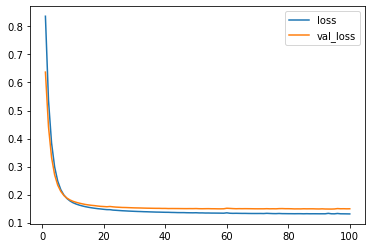

In [35]:
# Create a DataFrame containing training history
multi_history_df = pd.DataFrame(fit_model_multi.history, index=range(1,len(fit_model_multi.history["loss"])+1))

# Plot the loss
multi_history_df.plot(y=["loss", "val_loss"])

<AxesSubplot:>

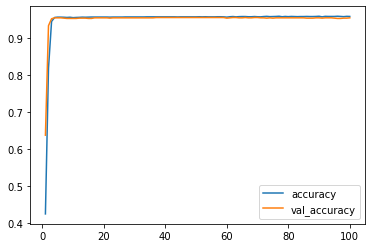

In [36]:
# Plot the accuracy
multi_history_df.plot(y=["accuracy", "val_accuracy"])

In [37]:
# Evaluate the model using the test data
model_loss, model_accuracy = multi_nn_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

39/39 - 0s - loss: 0.1492 - accuracy: 0.9552 - 108ms/epoch - 3ms/step
Loss: 0.14921671152114868, Accuracy: 0.9552116990089417


## Deep Learning Neural Network

In [38]:
# Define the model - deep neural net
number_input_features = len(X_train[0])
hidden_nodes_layer1 = 8
hidden_nodes_layer2 = 5

Deep_nn_model = tf.keras.models.Sequential()

# First hidden layer
Deep_nn_model.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
Deep_nn_model.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
Deep_nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
Deep_nn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 8)                 176       
                                                                 
 dense_5 (Dense)             (None, 5)                 45        
                                                                 
 dense_6 (Dense)             (None, 1)                 6         
                                                                 
Total params: 227
Trainable params: 227
Non-trainable params: 0
_________________________________________________________________


In [39]:
# Compile the model
Deep_nn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [40]:
# Train the model
fit_model_deep = Deep_nn_model.fit(X_train,y_train, validation_data = (X_test_scaled, y_test), epochs=100)

Epoch 1/100
116/116 [==============================] - 2s 6ms/step - loss: 0.4682 - accuracy: 0.8810 - val_loss: 0.5637 - val_accuracy: 0.7451
Epoch 2/100
116/116 [==============================] - 0s 4ms/step - loss: 0.2308 - accuracy: 0.9579 - val_loss: 0.5461 - val_accuracy: 0.7606
Epoch 3/100
116/116 [==============================] - 0s 4ms/step - loss: 0.1947 - accuracy: 0.9576 - val_loss: 0.5396 - val_accuracy: 0.7793
Epoch 4/100
116/116 [==============================] - 0s 4ms/step - loss: 0.1792 - accuracy: 0.9554 - val_loss: 0.5001 - val_accuracy: 0.8510
Epoch 5/100
116/116 [==============================] - 1s 4ms/step - loss: 0.1685 - accuracy: 0.9552 - val_loss: 0.5013 - val_accuracy: 0.8583
Epoch 6/100
116/116 [==============================] - 0s 4ms/step - loss: 0.1627 - accuracy: 0.9563 - val_loss: 0.4900 - val_accuracy: 0.8795
Epoch 7/100
116/116 [==============================] - 1s 5ms/step - loss: 0.1641 - accuracy: 0.9565 - val_loss: 0.4790 - val_accuracy: 0.8925

Epoch 58/100
116/116 [==============================] - 0s 4ms/step - loss: 0.1451 - accuracy: 0.9576 - val_loss: 0.2169 - val_accuracy: 0.9560
Epoch 59/100
116/116 [==============================] - 1s 5ms/step - loss: 0.1559 - accuracy: 0.9538 - val_loss: 0.2144 - val_accuracy: 0.9560
Epoch 60/100
116/116 [==============================] - 1s 5ms/step - loss: 0.1432 - accuracy: 0.9576 - val_loss: 0.2145 - val_accuracy: 0.9560
Epoch 61/100
116/116 [==============================] - 1s 5ms/step - loss: 0.1430 - accuracy: 0.9576 - val_loss: 0.2139 - val_accuracy: 0.9560
Epoch 62/100
116/116 [==============================] - 1s 6ms/step - loss: 0.1434 - accuracy: 0.9576 - val_loss: 0.2140 - val_accuracy: 0.9560
Epoch 63/100
116/116 [==============================] - 1s 4ms/step - loss: 0.1466 - accuracy: 0.9560 - val_loss: 0.2129 - val_accuracy: 0.9560
Epoch 64/100
116/116 [==============================] - 1s 5ms/step - loss: 0.1429 - accuracy: 0.9579 - val_loss: 0.2119 - val_accuracy:

<AxesSubplot:>

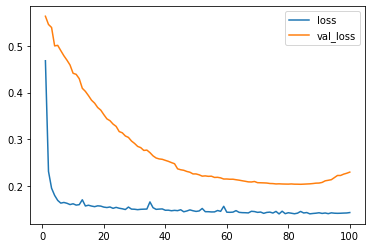

In [41]:
# Create a DataFrame containing training history
deep_history_df = pd.DataFrame(fit_model_deep.history, index=range(1,len(fit_model_deep.history["loss"])+1))

# Plot the loss
deep_history_df.plot(y=["loss", "val_loss"])

<AxesSubplot:>

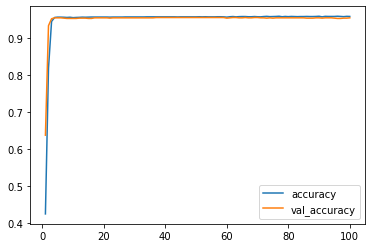

In [42]:
# Plot the accuracy
multi_history_df.plot(y=["accuracy", "val_accuracy"])

In [43]:
# Evaluate the model using the test data
model_loss, model_accuracy = Deep_nn_model.evaluate(X_test,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

39/39 - 0s - loss: 0.1500 - accuracy: 0.9560 - 121ms/epoch - 3ms/step
Loss: 0.14996367692947388, Accuracy: 0.9560260772705078
